# Drift Detection using Alibi Detect

Import dependencies

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
Load the iris dataset

In [2]:
iris = load_iris()
training_df = pd.DataFrame(iris.data, columns=iris.feature_names)
training_df.shape[0]

150

In [3]:
training_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's say that we have collected some input data from the production deployment of our model...

In [4]:
!python ../scripts/fake-production-data.py -n 150 -o fake-production-data.csv

Now we want to detect potential drifts, i.e., we want to check if the data is still coming from the same distribution as the data we used to train our model.

First, we read in our production data.

In [5]:
fake_production_df = pd.read_csv("fake-production-data.csv", header=None)
fake_production_df.columns = training_df.columns
fake_production_df.shape[0]

150

In [6]:
fake_production_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.9,4.4,2.1,2.5
1,6.8,4.0,6.3,0.5
2,5.2,4.0,1.5,0.5
3,6.8,2.5,5.0,2.0
4,4.7,2.5,6.4,2.3


Let's visualize the different distributions:

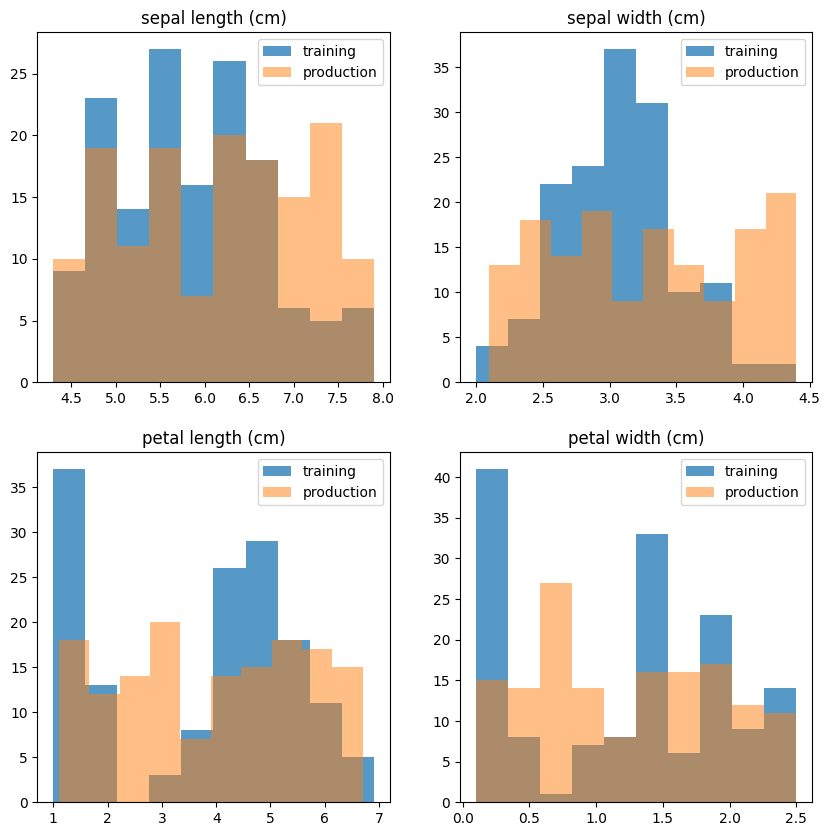

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(training_df["sepal length (cm)"], alpha=0.75, label="training")
axs[0, 0].hist(fake_production_df["sepal length (cm)"], alpha=0.50, label="production")
axs[0, 0].set_title("sepal length (cm)")
axs[0, 0].legend()
axs[0, 1].hist(training_df["sepal width (cm)"], alpha=0.75, label="training")
axs[0, 1].hist(fake_production_df["sepal width (cm)"], alpha=0.50, label="production")
axs[0, 1].set_title("sepal width (cm)")
axs[0, 1].legend()
axs[1, 0].hist(training_df["petal length (cm)"], alpha=0.75, label="training")
axs[1, 0].hist(fake_production_df["petal length (cm)"], alpha=0.50, label="production")
axs[1, 0].set_title("petal length (cm)")
axs[1, 0].legend()
axs[1, 1].hist(training_df["petal width (cm)"], alpha=0.75, label="training")
axs[1, 1].hist(fake_production_df["petal width (cm)"], alpha=0.50, label="production")
axs[1, 1].set_title("petal width (cm)")
axs[1, 1].legend()

# Measuring drift for **univariate features**

## Kolmogorov-Smirnov test (KS)

Let's build a drift detector for a single feature (`sepal length (cm)`) using the Kolmogorov-Smirnov test with p-value set to 0.01.

In [8]:
from alibi_detect.cd import KSDrift

sepal_drift_detector = KSDrift(training_df["sepal length (cm)"].to_numpy(), p_val=0.01)

/Users/luigiquaranta/.pyenv/versions/3.10.2/envs/fastapi_demo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


We can now use the drift detector to check if the production data is still coming from the same distribution as the training data.

In [9]:
sepal_drift_detector.predict(fake_production_df["sepal length (cm)"].to_numpy(), return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.22], dtype=float32),
  'p_val': array([0.00114359], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift'}}

As the p-value is lower than the threshold – i.e., 0.001 < 0.01 – we can reject the null hypothesis that the data comes from the same distribution as the training data. Therefore, we can conclude that there is a drift (`is_drift = 1`).

# Measuring drift for **multivariate features**

## Kolmogorov-Smirnov test (KS)

We can use the same type of drift detector for multivariate features. Let's build a drift detector for all the features from the Iris dataset using the Kolmogorov-Smirnov test with p-value set to 0.01.

In [10]:
drift_detector = KSDrift(training_df.to_numpy(), p_val=0.01)

Now the detector can be applied to all the features from the production data.

In [11]:
drift_detector.predict(fake_production_df.to_numpy(), return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.22      , 0.24666667, 0.19333333, 0.18666667], dtype=float32),
  'p_val': array([0.00114359, 0.00016651, 0.00625558, 0.00923657], dtype=float32),
  'threshold': 0.0025},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift'}}

Also in this case we can clearly detect a drift.

## Resources

- [Made With ML > Monitoring Machine Learning Systems > Measuring Drift](https://madewithml.com/courses/mlops/monitoring/#measuring-drift)
- [Alibi Detect Docs > Examples > Categorical and mixed type data drift detection on income prediction](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_chi2ks_adult.html)